# A Bayesian RL Implementation(OpenAI Gym) by Kasra Amini

## ''NChain-v0'' 

### Based on Dearden et al.(1998) paper [Bayesian Q-Learning](https://www.aaai.org/Papers/AAAI/1998/AAAI98-108.pdf)

### Supervisor: Dr Heena Rathore

This is a trial for reproducing the paper's result.

### Algorithm:
   - For *Action Selection* : **Q_Sampling**
   - For *Update Method* : **Moment Updating** 


# 1

## Imports and Dependencies

You need to install **gym, numpy, and matplotlib** via pip or conda. 

Then import *gym and numpy* libraries. To show Graph results we also need *matplotlib*.

In [5]:
import gym
import numpy as np
import random
import math
import matplotlib.pyplot as plt

# 2 

## The Agent

Next part is the Agent class, which almost includes the main code. 

This class takes a shape tuple that inckudes the number of states and the number of actions for the enviornment. Thus, can be used For other eniornments than 'NChain-v0'. Then the Normal Gamma Distribution is formed.

### Methods: 
1. argmax: it choses the best action 

2. moment_updating: implementation based on:
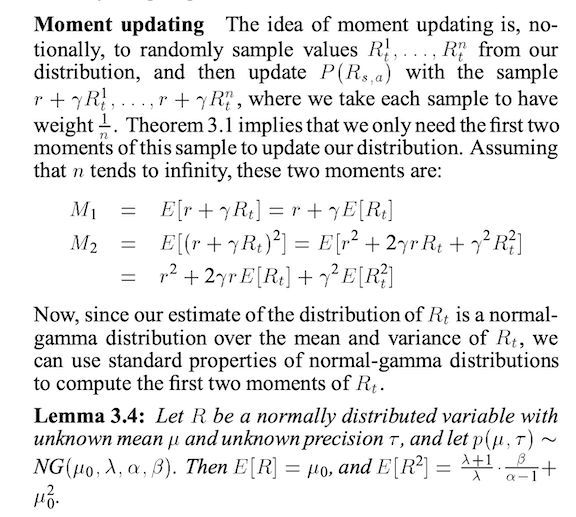

3. update: a wrapper so can be called in the env system by gym. it calls the agent moment update implemented.

4. Q_value_sampling: implementation based on the paper but with the T_Student distribution which is better for the variance.  


5. select_action: a wrapper so can be called in the env system by gym. it calls the Q-value-sampling method.



In [6]:
class Agent(object):
    
   
    def __init__(self, shape, gamma=0.99):


        self.Num_States = shape[0]
        self.Num_Actions = shape[1]
        self.discount_factor = gamma
        
        #Normal Gamma Dist Init
        self.NG = np.zeros(shape=shape, dtype=(float,4))
        for state in range(self.Num_States):
            for action in range(self.Num_Actions):
                #lambeda
                self.NG[state][action][1] = 3.0
                #alpha
                self.NG[state][action][2] = 1.4 
                #beta
                self.NG[state][action][3] = 0.80
                
    
    def argmax(self,a):

        #If action 'a' has only one max it is the argmax, if many exist one will be randomly picked.
    
        indeces = np.where(np.array(a) == np.max(a))[0]
        return np.random.choice(indeces)


    
    def moment_updating(self, state, action, reward, next_state, done):
        NG = self.NG
        mean = NG[state][action][0]
        lamb = NG[state][action][1]
        alpha = NG[state][action][2]
        beta = NG[state][action][3]

        if not done:

            #sample the next best action at next state
            means = NG[next_state, :, 0]
            next_action = self.argmax(means)

            mean_next = NG[next_state][next_action][0]
            lamb_next = NG[next_state][next_action][1]
            alpha_next = NG[next_state][next_action][2]
            beta_next = NG[next_state][next_action][3]

            #the first two moments of samples 
            M1 = reward + self.discount_factor*mean_next
            M2 = reward**2 + 2*self.discount_factor*reward*mean_next + self.discount_factor**2*(((lamb_next + 1)*beta_next)/(lamb_next*(alpha_next-1)) + mean_next**2)

            #updating the distribution
            self.NG[state][action][0] = (lamb*mean+M1)/(lamb+1)
            self.NG[state][action][1] = lamb + 1
            self.NG[state][action][2]= alpha + 0.5
            self.NG[state][action][3]= beta + 0.5*(M2-M1**2) + (lamb*(M1-mean)**2)/(2*(lamb + 1))

            
    
    
    def update(self, state, action, reward, next_state, done):
        #wrapper
        self.moment_updating(state, action, reward, next_state, done)
    
    
    def Q_value_sampling(self, NG, state):
        #Sample one value for each action
        samples = np.zeros(self.Num_Actions)
        
        for i in range(self.Num_Actions):
            mean = NG[state][i][0]
            lamb = NG[state][i][1]
            alpha = NG[state][i][2]
            beta = NG[state][i][3]

            '''
            It is better to sample from the T-student because in this way we don't need to sample first tau and then
            mu, this reduces the variance.
            '''
            

            samples[i] = np.random.standard_t(2*alpha) * np.sqrt(beta / (alpha * lamb)) + mean
        return self.argmax(samples)
    
    
    def select_action(self, state):
        #wrapper
        return self.Q_value_sampling(self.NG, state)

# 3

## Testing

This section has the run function to test our code in the **'NChain-v0'**.

I set it to run 10 Episodes just like the paper's calculation that is for 10 runs.

Each Episode contains 2 phases each of which consists of 1000 steps.

Note that: due to the Gym Env limitaion you can not set number of steps taken at each run more than 1000(I think for benchmarking purposes.), if you want more you should change the advanced settings of the ENV. 

## Scores

For the scoring, each Phase's score is stored in a seperate array. Then the mean, and standard Dev of 10 Episodes is calculated.

To reproduce the graph in the paper I calcuated the actual discounted reward in each Episode and stored it.
After 10 runs I summed all the rewards at each step in each phase together and plotted the cumulative average to each steps like the paper. 

**Paper's result:**

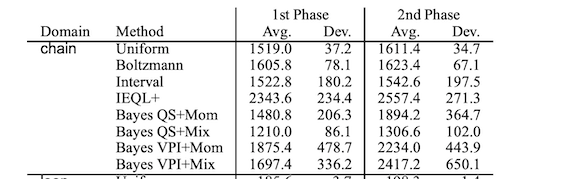

**Note that the paper has alos stated that the graph is smoothed so it is not identical in that case.**


**Results of scores are almost simillar, but the deviation is less in my code because I used T_Student for the Q-value Sampling.** 

Note:

Since I am not an expert, the code seems to sometimes generate unexpected behaviors! I tried to debug it, but I think it is because my lack of knowledge in statistics. I am unsure of the initial values for the Normal Distribution and also the Q-value sampling technique I used.   




In [36]:
def run(num_episodes, len_episode):
    # Initializing the  environment
    env = gym.make("NChain-v0")
    Num_States = env.observation_space.n
    Num_Actions = env.action_space.n
    Num_Steps = len_episode
    # Score arrays for each phase
    scores1 = np.zeros(num_episodes) 
    scores2 = np.zeros(num_episodes)
    # Actual discounted rewards for plotting
    rewards = np.zeros(2*Num_Steps)
    discounted_rewards = []
    
    for episode in range(num_episodes):
        agent=Agent(shape=(Num_States, Num_Actions))
        
        #learning phases
        for p in range(2):
            # Reset the environment
            obv = env.reset()
            # the initial state
            state_0 =obv
            
            score=0
            
            done = False
            
            i=0
            for i in range(Num_Steps):
                # Select the action
                action = agent.select_action(state_0)
                
                # Observe the result
                obv, reward, done, _ = env.step(action)
                score+=reward
                rewards[p*1000+i] = reward*agent.discount_factor**i
                
                # Update belief
                state = obv
                agent.update(state_0, action, reward, state, done)
                
                # Setting up for the next iteration
                state_0 = state
                if done:
                    print("Episode {}:Phase {} finished after {} time steps with score={}".format(episode+1 ,p+1, i+1, score))
                    break
                    
            # Store each phase's scores 
            if p == 0:
                scores1[episode]=score
            else:
                scores2[episode]=score
                
        # Store each episode's discounted reward
        discounted_rewards.append(rewards)
        
    # Calculate the mean of the discounted rewards     
    real_discounted_reward = np.zeros(2000)
    
    for reward in discounted_rewards:
        real_discounted_reward += reward
        
    real_discounted_reward //= num_episodes
    
    # Calculate the cumulative sum of 10 runs rewards to plot
    rew = np.cumsum(real_discounted_reward)
    print(100 * "-",'\n')
    
    # Printing the result
    print(20*' ',"Phase 1",20*' ',"Phase 2")
    print("Avg.:",15*" ",np.mean(scores1),20*" ",np.mean(scores2))
    print("Dev.:",15*" ","{:.1f}".format(np.std(scores1)),22*" ","{:.1f}".format(np.std(scores2)))
    
    # Plotting the result
    plt.style.use('bmh')
    _, ax = plt.subplots()
    ax.plot(rew, label='Bays QS+Mom')
    ax.set_xlabel('Steps')
    ax.set_ylabel('Accumulated Discounted Reward')
    ax.legend(loc='lower right')

    plt.show()

Testing Begins
Episode 1:Phase 1 finished after 1000 time steps with score=1756
Episode 1:Phase 2 finished after 1000 time steps with score=1710
Episode 2:Phase 1 finished after 1000 time steps with score=1616
Episode 2:Phase 2 finished after 1000 time steps with score=1654
Episode 3:Phase 1 finished after 1000 time steps with score=1562
Episode 3:Phase 2 finished after 1000 time steps with score=1572
Episode 4:Phase 1 finished after 1000 time steps with score=2490
Episode 4:Phase 2 finished after 1000 time steps with score=3150
Episode 5:Phase 1 finished after 1000 time steps with score=1602
Episode 5:Phase 2 finished after 1000 time steps with score=1588
Episode 6:Phase 1 finished after 1000 time steps with score=1640
Episode 6:Phase 2 finished after 1000 time steps with score=1496
Episode 7:Phase 1 finished after 1000 time steps with score=1452
Episode 7:Phase 2 finished after 1000 time steps with score=1656
Episode 8:Phase 1 finished after 1000 time steps with score=1780
Episode 8:

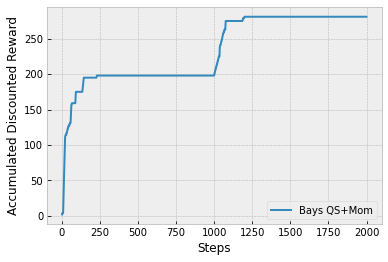

In [35]:
if __name__ == "__main__":
    print("Testing Begins")
    run(10, 1000)